# [Adopt a Buddy Challenge in HackerEarth](https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-pet-adoption/)

## Problem Statement as mentioned in the challenge

A leading pet adoption agency is planning to create a virtual tour experience for their customers showcasing all animals that are available in their shelter. To enable this tour experience, you are required to build a Machine Learning model that determines type and breed of the animal based on its physical attributes and other factors.

## My observations in the problem statement.

* Physical attributes of the animals is given
   - Which are features
   - Examples:- Height, Weight, color, etc,...
* We have to predict two targets
    - Breed Category and Pet Category
* This is a Multiclassification Problem.
* Each target has multiple classes

### First I imported all the libraries required

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from lightgbm import LGBMClassifier
import lightgbm

### Reading the train dataset

In [2]:
df=pd.read_csv('train.csv')

### Visualize the train dataset

In [3]:
df=pd.DataFrame(df)
df.head() #This shows the top five rows in the dataframe

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4
3,ANSL_71623,2016-12-31 00:00:00,2019-01-25 18:30:00,1.0,White,0.62,17.82,0,1,0.0,2
4,ANSL_57969,2017-09-28 00:00:00,2017-11-19 09:38:00,2.0,Black,0.50,11.06,18,4,0.0,1


### Let's see some basic statistical details like percentile, mean, std etc. of a data frame.

<pre style="background-color:yellow;color:red"> df.describe() </pre> Give a table of all columns which has 
* the number of rows in the column (count),
* average of each column (mean),
* deviation from mean (std), 
* minimum value in column (min),
* 25th percentile of column (25%),
* 50th percentile of column (50%),
* 75th percentile of column (75%),
* maximum value in column (max)

In [4]:
df.describe()

,condition,length(m),height(cm),X1,X2,breed_category,pet_category
count,17357.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000
mean,0.883390,0.502636,27.448832,5.369598,4.577307,0.600563,1.709143
std,0.770434,0.288705,13.019781,6.572366,3.517763,0.629883,0.717919
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,16.172500,0.000000,1.000000,0.000000,1.000000
50%,1.000000,0.500000,27.340000,0.000000,4.000000,1.000000,2.000000
75%,1.000000,0.760000,38.890000,13.000000,9.000000,1.000000,2.000000
max,2.000000,1.000000,50.000000,19.000000,9.000000,2.000000,4.000000


### See the any null values are present in the dataframe.

<pre style="background-color:yellow;color:red"> df.count() </pre>

Gives the count of number of rows without **NaN** value in each column.

In [5]:
df.count()

pet_id            18834
issue_date        18834
listing_date      18834
condition         17357
color_type        18834
length(m)         18834
height(cm)        18834
X1                18834
X2                18834
breed_category    18834
pet_category      18834
dtype: int64

### We can see there are few null values in dataframe in the condition column. Let us fill those null values with the mean of the condition column.  _This is a part_ of Preproceesing of data

<pre style="background-color:yellow;color:red"> df.fillna() </pre>
Used for filling the **NaN** values in the dataframe with our specified values. In this case, filled with mean of the column.

In [6]:
df['condition'].fillna((df['condition'].mean()), inplace=True)

### See whether null values are filled with mean.

In [7]:
df.count()

pet_id            18834
issue_date        18834
listing_date      18834
condition         18834
color_type        18834
length(m)         18834
height(cm)        18834
X1                18834
X2                18834
breed_category    18834
pet_category      18834
dtype: int64

#### Now null values are filled with mean.

### Let's visualize the correlation between columns in dataframe.

*Correlation is a measure of how strongly one feature depends on anothers.*

---

To know more about heatmap, [Click Here](https://seaborn.pydata.org/generated/seaborn.heatmap.html)

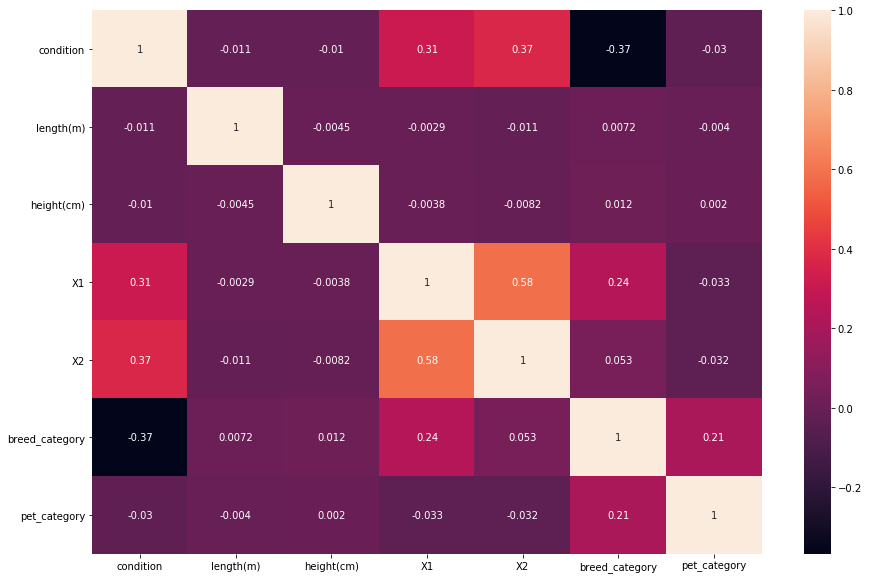

In [8]:
import seaborn as sns
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

#### Observations From HeatMap

* Every column is highly correlated with itself.(Eg.: condition column is highly correlated itself i.e.,1)
* As the correlation value is high the more they are related with each other.
* There is no relation between condition and breed category.
* X1 and X2 are more related with each other.
* similarly,X1 and breed category, pet category and breed category.

---

Basing on the above heat map, we select few columns which can give more accurate predictions.

### Let's extract required columns.

In [9]:
tdata=df[["condition","length(m)","height(cm)","X1","X2"]]

In [10]:
tdata.head() #shows top five rows in dataframe

,condition,length(m),height(cm),X1,X2
0,2.00000,0.80,7.78,13,9
1,1.00000,0.72,14.19,13,9
2,0.88339,0.15,40.90,15,4
3,1.00000,0.62,17.82,0,1
4,2.00000,0.50,11.06,18,4


## *Let's do some* Feature Engineering.

### 1. Converting cm (centimeters) to m(meters)

Converting all measurements into same metrics gives more understand.

### 2. [Encoding categorical data](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html#sklearn-preprocessing-labelencoder) into numbers.

Here color column has 56 distinct colors, so we can replace names with values for using it as a feature.

In [11]:
tdata['height(cm)']=tdata['height(cm)']/100 #conveting centimeters to meters



le = preprocessing.LabelEncoder() #defining labelencoder object
le.fit(df['color_type']) #fitting with color_type column
tdata['color_type']=le.transform(df['color_type']) #encoding color_type column

C:\Users\k. Lakshmiteja\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\k. Lakshmiteja\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
le.transform(df['color_type']) #assigns a constant number to each distinct color

array([18, 53, 15, ..., 22, 48, 15])

## Let's again visualize the heatmap for correlation with color column

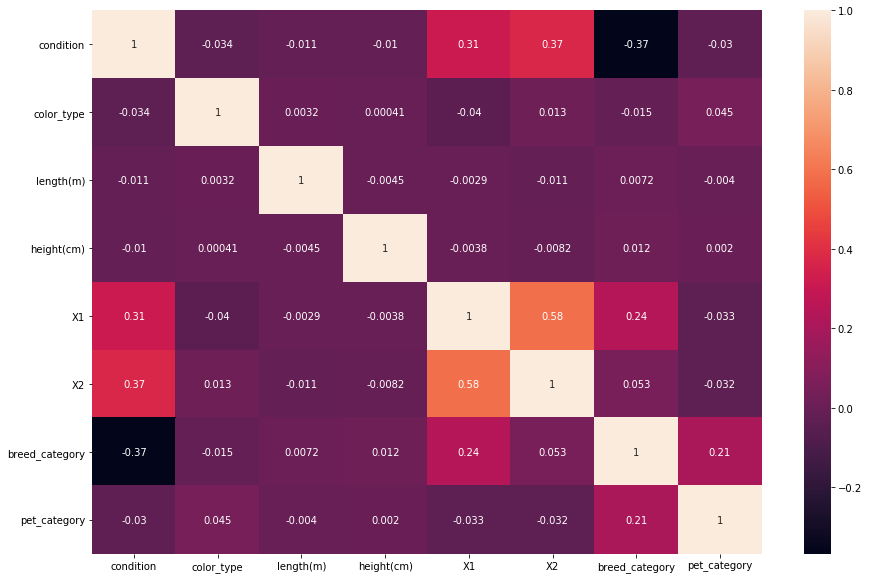

In [15]:
df['color_type']=le.transform(df['color_type'])

plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),annot=True)

**Here you can see some correlations with color_type column.**

### Extracting target columns from the dataframe

In [32]:
testdata=pd.DataFrame(df[["breed_category", "pet_category"]])
testdata.head()

,breed_category,pet_category
0,0.0,1
1,0.0,2
2,2.0,4
3,0.0,2
4,0.0,1


## Training with [LightGBM Classifier](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [33]:
%%time

regr1= LGBMClassifier()
regr2= LGBMClassifier()

# regr1=GradientBoostingClassifier(random_state=0) # Try this also, can work well.
# regr2=GradientBoostingClassifier(random_state=0) # Try this also, can work well.

regr1.fit(tdata, testdata['breed_category'])
regr2.fit(tdata, testdata['pet_category'])

Wall time: 2.27 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## Making Test dataset similar to Train dataset

In [34]:
testcsvdf=pd.DataFrame(pd.read_csv('test.csv'))
testcsv=testcsvdf[["condition","length(m)","height(cm)","X1","X2"]]
testcsv['height(cm)']=testcsv['height(cm)']/100
testcsv["condition"].fillna((testcsv['condition'].mean()), inplace=True)
testcsv['color_type']=le.transform(testcsvdf['color_type'])

C:\Users\k. Lakshmiteja\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\k. Lakshmiteja\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\k. Lakshmiteja\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

## Making predictions on Testdata

In [35]:
y_pred1=regr1.predict(testcsv)
y_pred2=regr2.predict(testcsv)
y_pred1=y_pred1.astype(int) #converting to int as the result of predict() is float in this case
y_pred2=y_pred2.astype(int)

## Creating the submission Dataframe as mentioned in the [Challenge](https://www.hackerearth.com/challenges/competitive/hackerearth-machine-learning-challenge-pet-adoption/)

In [81]:
dataset = pd.DataFrame({'pet_id':testcsvdf['pet_id'],'breed_category': y_pred1, 'pet_category':y_pred2})
dataset

,pet_id,breed_category,pet_category
0,ANSL_75005,1,2
1,ANSL_76663,0,1
2,ANSL_58259,0,2
3,ANSL_67171,0,1
4,ANSL_72871,0,2
...,...,...,...
8067,ANSL_66809,0,2
8068,ANSL_59041,1,2
8069,ANSL_60034,1,2
8070,ANSL_58066,2,4


## Saving the Dataframe as a csv file.

In [82]:
dataset.to_csv("E:\submission.csv",index=False)
res=pd.read_csv(r'E:\submission.csv')
res

,pet_id,breed_category,pet_category
0,ANSL_75005,1,2
1,ANSL_76663,0,1
2,ANSL_58259,0,2
3,ANSL_67171,0,1
4,ANSL_72871,0,2
...,...,...,...
8067,ANSL_66809,0,2
8068,ANSL_59041,1,2
8069,ANSL_60034,1,2
8070,ANSL_58066,2,4
